<a href="https://colab.research.google.com/github/Angel0503/DeepLearning/blob/master/TD3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf


## Exercice 1 - Séries temporelles

### 1 - Télécharger un dataset contenant l’historique des cotations d’une action de votre choix (votre entreprise en alternance, facebook, google, CAC40, etc.). Vous trouverez ce qu’il faut ici : https://www.nasdaq.com. Il est conseillé de prendre la plus grande période possible pour avoir le dataset le plus grand possible

### 2 - Charger le fichier CSV en python et explorer le dataset. Proposer une ou plusieurs représentations graphiques permettant de visualiser les données.

In [119]:
df = pd.read_csv('NVIDIA_stocks.csv')

In [120]:
df.describe()

,Volume
count,2.514000e+03
mean,4.594593e+08
std,2.556077e+08
min,5.244924e+07
25%,2.945382e+08
50%,4.104501e+08
75%,5.597640e+08
max,3.688132e+09


In [121]:
df.head(10)

,Date,Close/Last,Volume,Open,High,Low
0,11/06/2025,$188.08,223029800,$196.42,$197.62,$186.38
1,11/05/2025,$195.21,171350300,$198.77,$202.92,$194.65
2,11/04/2025,$198.69,188919300,$203.00,$203.9699,$197.93
3,11/03/2025,$206.88,180267300,$208.08,$211.335,$205.56
4,10/31/2025,$202.49,179802200,$206.45,$207.97,$202.07
5,10/30/2025,$202.89,178864400,$205.15,$206.16,$201.41
6,10/29/2025,$207.04,308829600,$207.98,$212.1899,$204.775
7,10/28/2025,$201.03,297986200,$193.05,$203.15,$191.91
8,10/27/2025,$191.49,153452700,$189.99,$192.00,$188.4318
9,10/24/2025,$186.26,131296700,$183.835,$187.47,$183.50


In [122]:
df.isnull().sum()

,0
Date,0
Close/Last,0
Volume,0
Open,0
High,0
Low,0


In [123]:
df.dtypes

,0
Date,object
Close/Last,object
Volume,int64
Open,object
High,object
Low,object


In [124]:
df['Close/Last'] = df['Close/Last'].apply(lambda x: float(x.split('$')[1]))
df['Date'] = pd.to_datetime(df['Date'])
df['Open'] = df['Open'].apply(lambda x: float(x.split('$')[1]))
df['High'] = df['High'].apply(lambda x: float(x.split('$')[1]))
df['Low'] = df['Low'].apply(lambda x: float(x.split('$')[1]))

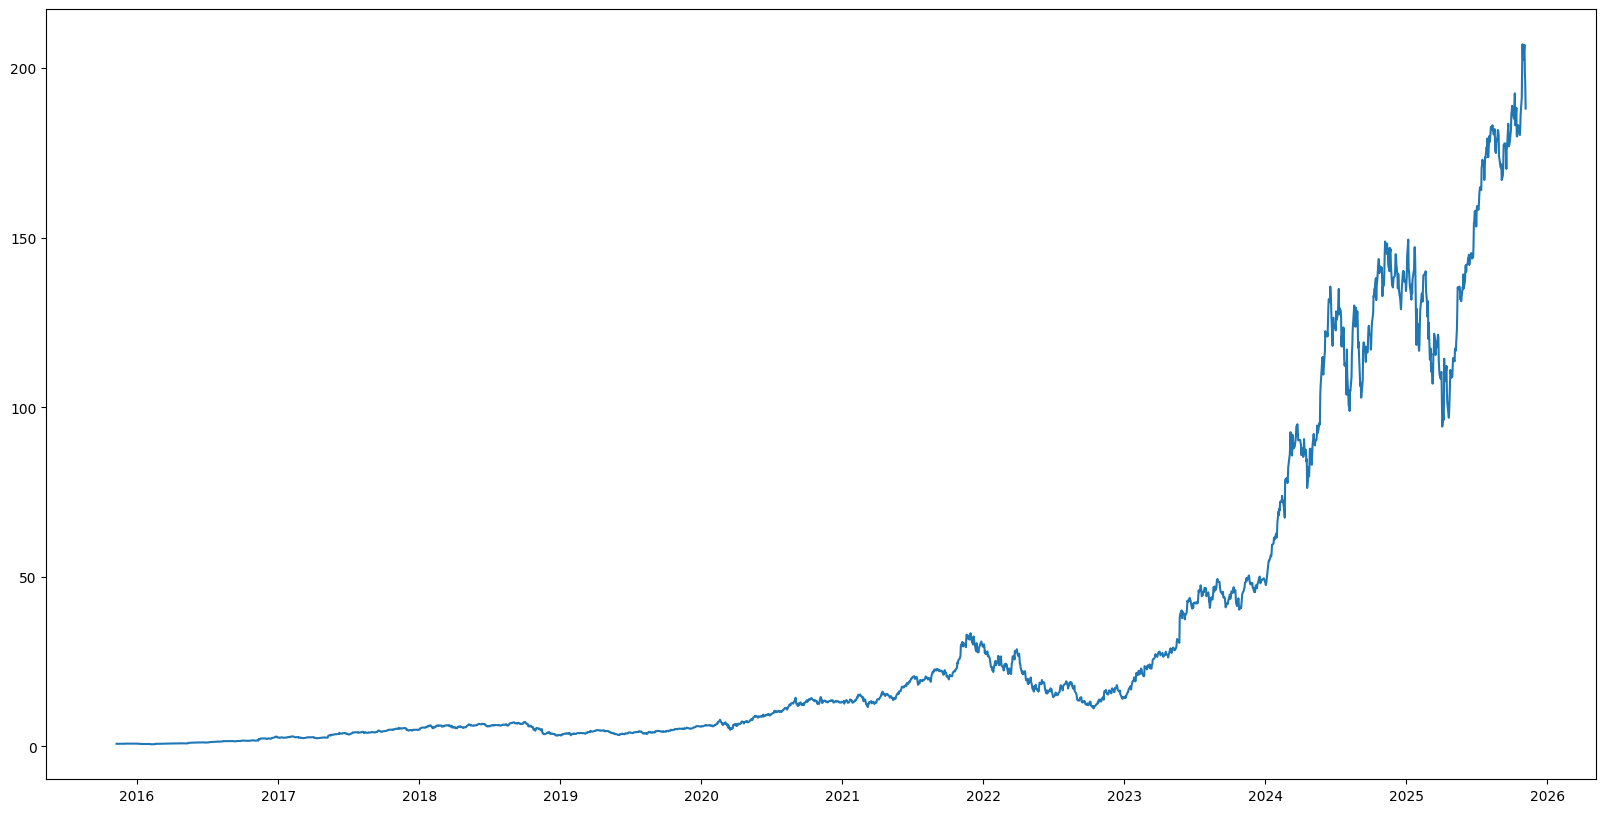

In [125]:
plt.figure(figsize=(20,10))
plt.plot(df['Date'], df['Close/Last'])
plt.show()

### 3 - Sélectionner la ou les colonnes permettant la prédiction les cotations de l’action sélectionnée.

In [126]:
df = df.sort_values('Date', ascending=True)
stock_values = df[['Close/Last']]

### 4 - Préparer un dataset d’entrainement et de test pour l’apprentissage. En particulier, le dataset doit être constitué de séquences de valeurs (en entrée) permettant de prédire la (ou les) valeur(s) suivante(s) de cette séquence (target).

MinMaxScaler sur les données

Créé algo pour créer dataset qui prend les 60 premières valeurs pour le X et la 61 eme est le Y sur tout le dataset.
Puis pour le train-test, il faut le faire à la main car il faut garder l'ordre.

#### Standardiser les données

In [127]:
scaler = MinMaxScaler()

scaler.fit_transform(stock_values)

array([[7.49965481e-04],
       [6.76809934e-04],
       [6.40958871e-04],
       ...,
       [9.59546436e-01],
       [9.42686746e-01],
       [9.08143763e-01]])

#### Créer la séquence

In [128]:
data_X = []
data_Y = []

def create_dataframe(data, decalage):
    X, y = [], []
    for i in range(len(data) - decalage):
        X.append(data[i:i+decalage].flatten())
        y.append(float(data[i+decalage]))
    return np.array(X), np.array(y)

data_X, data_Y = create_dataframe(stock_values.values, 60)


/tmp/ipython-input-1441179009.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y.append(float(data[i+decalage]))


In [129]:
print(data_X.shape)
print(data_Y.shape)

(2454, 60)
(2454,)


In [130]:
df = pd.DataFrame({'x':data_X.tolist(), 'y':data_Y})

#### Générer le jeu de test et train

In [131]:
n = len(df)
split_idx = int(n * 0.7)

train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

print(train_df.shape, test_df.shape)

(1717, 2) (737, 2)


In [132]:
X_train = np.array(train_df['x'].tolist())
y_train = train_df['y'].values

X_test = np.array(test_df['x'].tolist())
y_test = test_df['y'].values

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1717, 60) (1717,)
(737, 60) (737,)


### 5 - Proposer et comparer quelques architectures neuronales à partir de couches LSTM et GRU. Sélectionner celle permettant d’obtenir les meilleurs résultats. Dans cette question, la prédiction doit être faite à très court terme. Vous pouvez aussi utiliser des couches convolutionnel 1D pour évaluer l’impact de la mémoire long terme.

In [156]:
model = tf.keras.Sequential()

# Couche d'entrée de 60 neuronnes
model.add(tf.keras.Input(shape=(60,1)))
# Couche LSTM
model.add(tf.keras.layers.LSTM(50, return_sequences=True))
model.add(tf.keras.layers.LSTM(50, return_sequences=True))
model.add(tf.keras.layers.LSTM(50))
# Couche de sortir dense de 1 neuronne sans fonction d'activation
model.add(tf.keras.layers.Dense(1, activation=None))

adam = tf.keras.optimizers.Adam()
model.compile(loss='mean_squared_error', optimizer=adam)

In [157]:
model.fit(X_train, y_train, epochs=100, verbose=1, batch_size=128)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - loss: 121.4041
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 213ms/step - loss: 72.8981
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - loss: 56.0716
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - loss: 33.3224
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 30.6459
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 26.2867
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 20.9643
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step - loss: 20.4643
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - loss: 17.2083
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - loss: 14.9187
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - loss: 13.9285
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - loss: 13.1507
Epoch 13/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step - loss: 12.4942
Epoch 14/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - loss: 11.7309
Epoch 15/100
14/14 ━━━━━━━━━

In [158]:
test_mse = model.evaluate(X_test, y_test, verbose=0)
print(f"Test mse : {test_mse:.4f}")

train_mse = model.evaluate(X_train, y_train, verbose=0)
print(f"Train mse : {train_mse:.4f}")

Test mse : 6862.2437
Train mse : 0.3241


## Exercice 2

déclage commme exo 1 ; faire un dictionnaire  